### `Task 2`
1. make sure you have `ML5G-PS-005_train.csv` and `ML5G-PS-005_test.csv` in same directory as this file
2. make sure you have `Task_data_handler.py` in same directory as this file

3. Change `time_t` (from 0 to 600) which is detection time and run-all cells in order to get the predictions
4. change   `num_features` (from 1 to 3325) which is number of features and run all cells to get the predictions

## Import the modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBClassifier, plot_importance

import Task_data_handler as Th

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Control number of features and detection time

remember to run all cells after changing `time_t` or `number of features`

In [2]:
time_t = 64
num_features = 1

In [3]:
# Get preposed dataset at detection time (time_t)
df, target, label, train_size = Th.get_df_preprocessed(time_limit=time_t)
print(df.shape, train_size)

(900, 3325) 600


<h2 font-family: MV Boli>Removing less important features  Columns</h2>

In [4]:
if num_features < 530:
    sel = DropConstantFeatures(tol=0.99, variables=None)
    sel.fit(df)
    df.drop(sel.features_to_drop_, axis=1, inplace=True)

    sel = DropDuplicateFeatures(variables=None)
    sel.fit(df)
    df.drop(sel.features_to_drop_, axis=1, inplace=True)

    sel = DropCorrelatedFeatures(threshold=0.90, method='spearman') # you can use other methods like kendall or spearman
    sel.fit(df)
    df.drop(sel.features_to_drop_, axis=1, inplace=True)

df.shape

(900, 549)

In [5]:
le = LabelEncoder()

xgb_model = XGBClassifier()
xgb_model.fit(df, le.fit_transform(target))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [6]:
importance_df = pd.DataFrame({'Features':df.columns, 'Importance': xgb_model.feature_importances_ })
importance_df.sort_values(by='Importance', inplace=True, ascending=False)

counter = 0
total_importance = 0
mean = importance_df.Importance.mean()
print('Total cols', len(importance_df), df.shape)
for i in range(len(importance_df)):
    total_importance += importance_df.iloc[i].Importance
    # if importance_df.iloc[i].Importance <= mean:
    if i >= num_features:
        df.drop(importance_df.iloc[i][0], axis=1, inplace=True)
        counter += 1
df.shape

Total cols 549 (900, 549)


(900, 1)

## Plot feature importance using `XGBC`

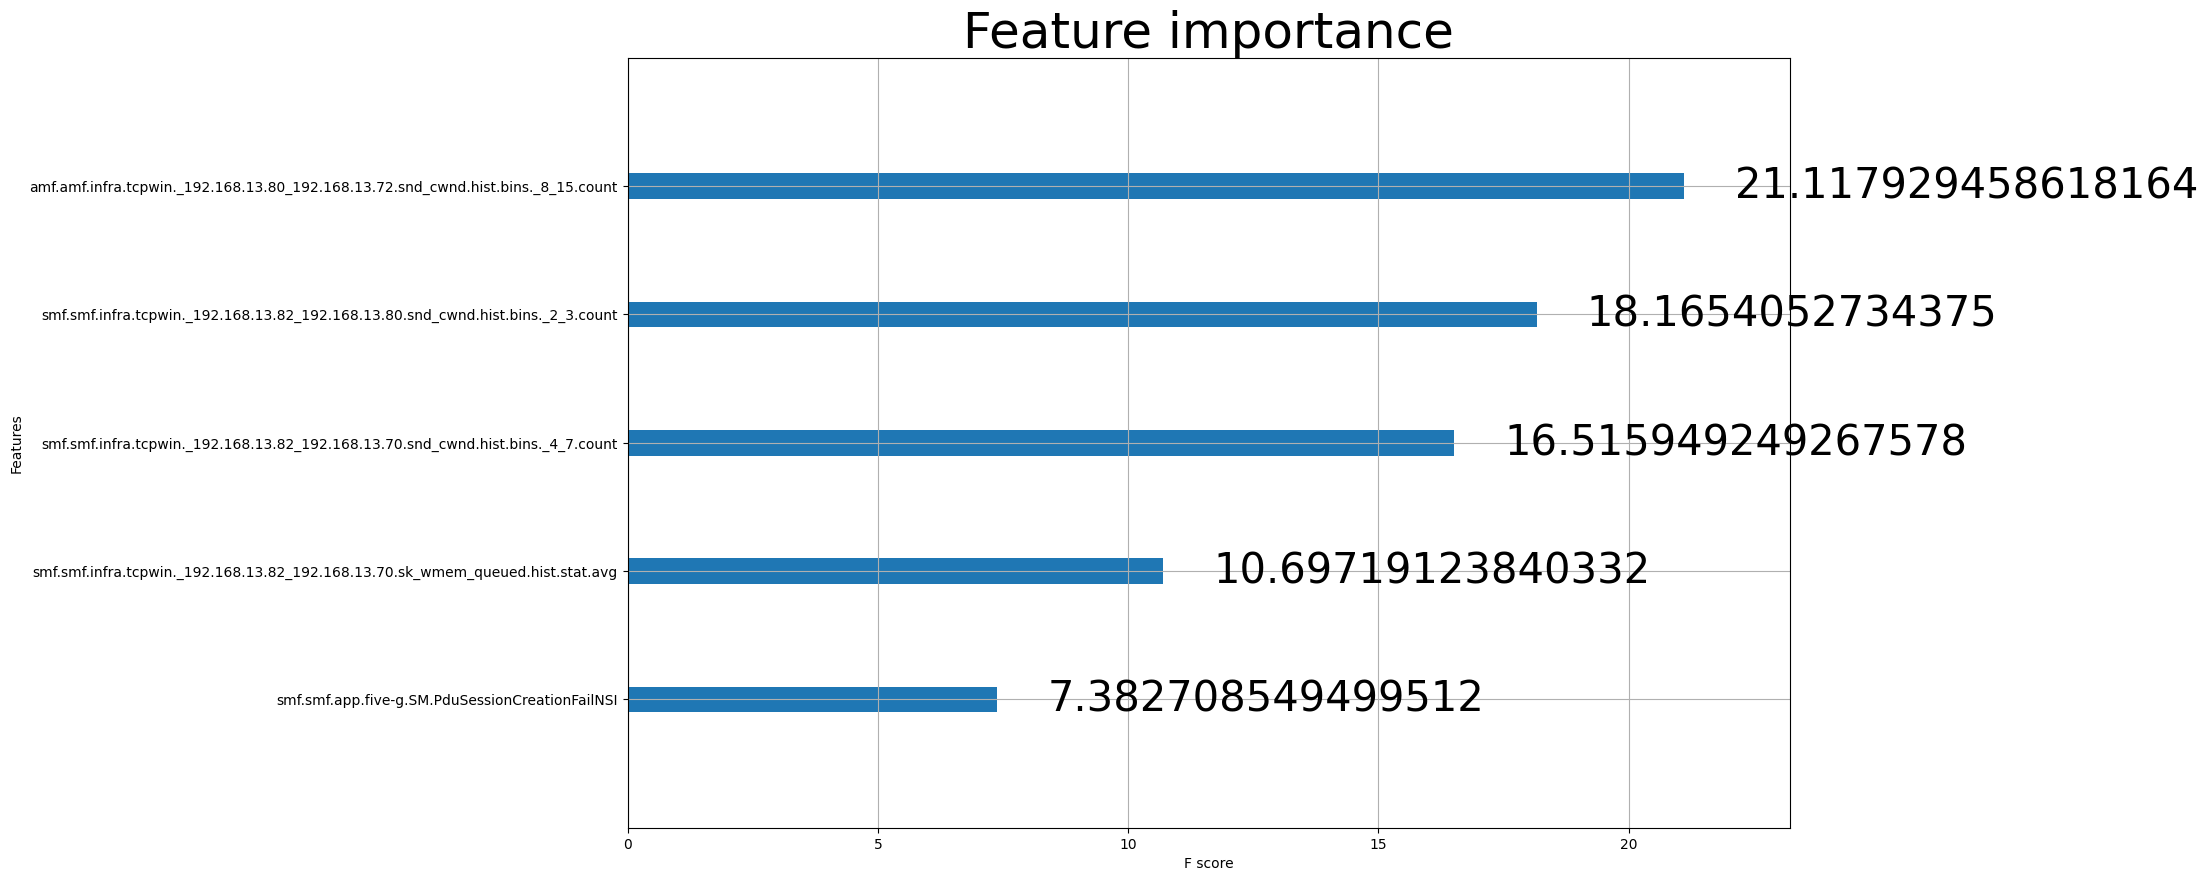

In [7]:
_, ax = plt.subplots(figsize=(15, 10))
plt.rc('font', size=30)
plt.rc('axes', labelsize=30) 
plot_importance(xgb_model, ax=ax, max_num_features=5, importance_type='gain')
plt.show()

## Split train and test datasets

In [8]:
X_train, y_train, X_test, y_test, train_label, test_label = Th.split(df, target, label, train_size)

## Smote (oversample) train data

In [9]:
X_train, train_label, y_train = Th.manage_imbalance(X_train, train_label, y_train)

# Models

## Use ``Threshold`` to separate the dataset

threshold is any value v in which if target value is about that value v, the network failure occurs and if it is less than the same value v, then network failure does not occur

use the predicted value array and threshold to generate true and false matrix in form of integers

In [10]:
def my_pred(pred, threshold=2):
    return (pred >= threshold).astype(int)

### creating instances of the `ML` models

In [11]:
le = LabelEncoder()
svr_model = SVR(C=0.09, kernel='sigmoid')
bayes_model = BayesianRidge()
cat_model = CatBoostRegressor()
xgbr_model = XGBRegressor()
random_forest_model = RandomForestRegressor()

### `Train` the models

In [12]:
bayes_model.fit(X_train, y_train)
xgbr_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train, verbose=250)

Learning rate set to 0.040267
0:	learn: 1.6009546	total: 140ms	remaining: 2m 19s
250:	learn: 1.4956629	total: 1.08s	remaining: 3.23s
500:	learn: 1.4502205	total: 1.81s	remaining: 1.8s
750:	learn: 1.4221172	total: 2.29s	remaining: 760ms
999:	learn: 1.4035209	total: 2.75s	remaining: 0us


## search for best threshold value

In [13]:
y = test_label.factorize()[0]
models ={ 
        'SVR': svr_model, 
        'Cat': cat_model,
        'XGBR' : xgbr_model,
        'Bayesian Ridge' : bayes_model,
        'Random Forest': random_forest_model,
}

min_threshold = 0
max_threshold = 100
steps = 1
if time_t < 150:
        max_threshold = 300
        steps = 100

results = pd.DataFrame(columns=['Model', 'F1', 'Threshold', 'Accurancy'])
for i in range(min_threshold, max_threshold):
    for name, model in models.items():
        pred = my_pred(model.predict(X_test), threshold=i/steps)
        accur = accuracy_score(y, pred)
        tmp_df = pd.DataFrame([[name, f1_score(y, pred, average=None)[0], i/steps, accur]], columns=['Model', 'F1', 'Threshold', 'Accurancy'])
        results = pd.concat([results, tmp_df], ignore_index=True)
results = results.sort_values(by=['F1', 'Accurancy'], ascending = [False, False])

## show one ```best``` result for each model 

In [14]:
# Write a Summary of the findings for recording purposes
print('num features:', df.shape[1], 'Time:', time_t)
top_models = []
summary = pd.DataFrame(columns=['Model', 'F1', 'Threshold'])
i = 0
while len(top_models) < len(models):
    if results.iloc[i]['Model'] not in top_models:
        tmp_df = pd.DataFrame([[results.iloc[i]['Model'], results.iloc[i]['F1'], results.iloc[i]['Threshold']]], columns=['Model', 'F1', 'Threshold'])
        summary = pd.concat([summary, tmp_df], ignore_index=True)
        top_models.append(results.iloc[i]['Model'])
        
        if results.iloc[i]['Model'] == 'SVR':
            threshold = results.iloc[i]['Threshold']
    i += 1
summary

num features: 1 Time: 64


,Model,F1,Threshold
0,Bayesian Ridge,0.980392,1.30
1,SVR,0.909091,1.31
2,XGBR,0.880952,2.25
3,Cat,0.876712,2.29
4,Random Forest,0.876543,1.62


## show `all` results

In [15]:
pd.set_option('display.max_rows', 20)
print('num features:', df.shape[1], 'Time:', time_t)
results

num features: 1 Time: 64


,Model,F1,Threshold,Accurancy
653,Bayesian Ridge,0.980392,1.30,0.970000
658,Bayesian Ridge,0.980392,1.31,0.970000
663,Bayesian Ridge,0.980392,1.32,0.970000
668,Bayesian Ridge,0.978261,1.33,0.966667
673,Bayesian Ridge,0.976139,1.34,0.963333
...,...,...,...,...
5,SVR,0.000000,0.01,0.163333
10,SVR,0.000000,0.02,0.163333
15,SVR,0.000000,0.03,0.163333
20,SVR,0.000000,0.04,0.163333


## show confusion matrix for `SVR Model` only

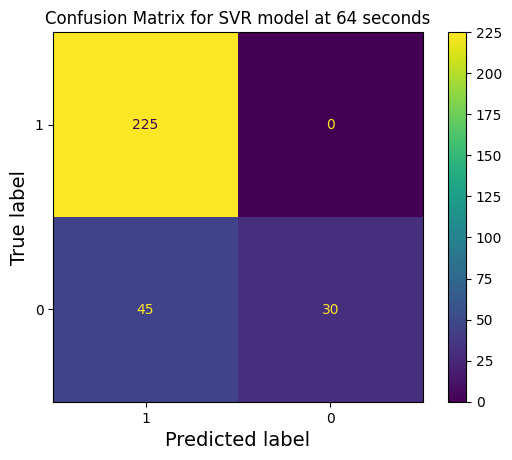

In [16]:
plt.rc('font', size=10)
plt.rc('axes', labelsize=14) 
cm = confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1, 0], )
cm_display.plot()
plt.title(f'Confusion Matrix for SVR model at {time_t} seconds')
plt.show()

## Calculate `F1-score` and compare it with the sklearn calculations

In [17]:
# Compare sklearn F1-Score calculations with my implememtation
def recall(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fp)

def precision(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fn)

def f1(matrix):
    return 2 * precision(matrix) * recall(matrix)/(precision(matrix)+recall(matrix))

print('Precision: ', precision(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('Recall:    ', recall(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('F1-score for my implementation F1:   ', f1(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('F1-score for Sklearn implementation: ', f1_score(y, my_pred(svr_model.predict(X_test), threshold=threshold), average=None)[0])


Precision:  0.8333333333333334
Recall:     1.0
F1-score for my implementation F1:    0.9090909090909091
F1-score for Sklearn implementation:  0.9090909090909091
